# Make a portrait

In [132]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [133]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bin.jpg'  
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(1920, 1280, 3)


In [134]:
serengeti_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/pyramid.jpg'
serengeti_img_orig = cv2.imread(serengeti_img_path) 
print (serengeti_img_orig.shape)

(425, 640, 3)


In [71]:
## Make Deeplab model

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    #Instead of directly implementing the model structure in __init__(), the graph structure graph_def read from the tar file is imported and used through tf.compat.v1.import_graph_def.
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
            tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # Numpy array of shape by Tensorflow
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # use sess.run(feed_dict={input...})
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [72]:
## Define model and download & load pretrained weight


_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = '~/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: ~/aiffel/human_segmentation/models
model loaded successfully!


In [73]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1920, 1280, 3) (513, 342, 3) 15


In [74]:
# labels
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

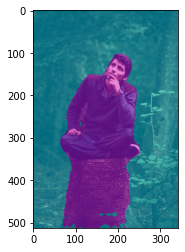

In [75]:
# make a show only 15 
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # only person
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_COOL)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

Original image size: (1280, 1920)
Transform mask size: (513, 342)


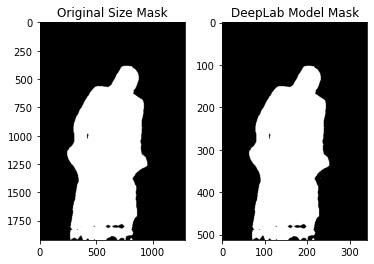

In [76]:
## Restoring the segmentation result to its original size

img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

print(f'Original image size: {img_orig.shape[:2][::-1]}\nTransform mask size: {img_mask.shape}')
ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

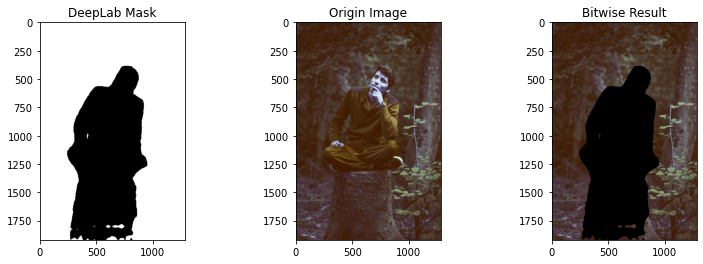

In [77]:
## Extract only the background using a segmentation mask

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

fig = plt.figure(figsize=(13, 4)) 

ax = plt.subplot(1,3,1)
plt.imshow(img_bg_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Mask')

ax = plt.subplot(1,3,2)
plt.imshow(img_orig, cmap=plt.cm.binary_r)
ax.set_title('Origin Image')

ax = plt.subplot(1,3,3)
plt.imshow(img_bg, cmap=plt.cm.binary_r)
ax.set_title('Bitwise Result')

plt.show()

Text(0.5, 1.0, 'Blur Processing')

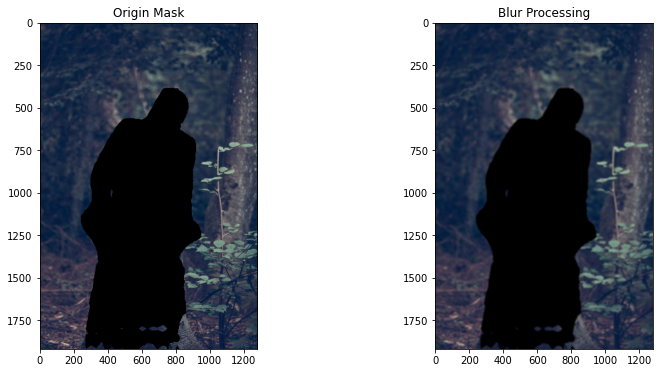

In [78]:
# Make a blur background
img_bg_blur = cv2.blur(img_bg, (12,12))

fig = plt.figure(figsize=(13, 6)) 

ax = plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Origin Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)
ax.set_title('Blur Processing')

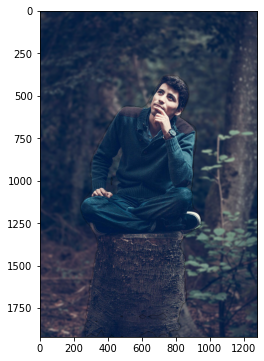

In [79]:
## Blurred background and original video composite

img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
fig = plt.figure(figsize=(16, 6)) 
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

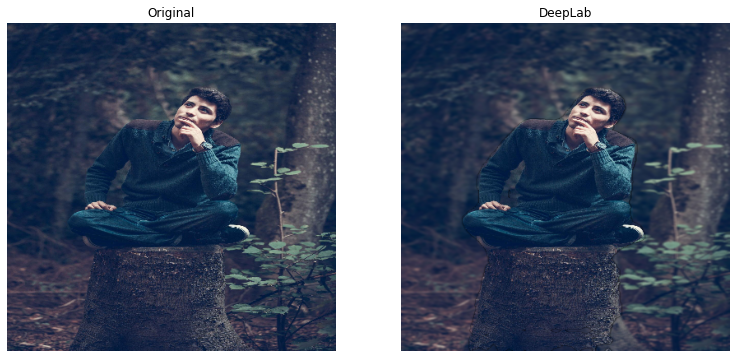

In [138]:
plt.figure(figsize=(20,20))
ax = plt.subplot(2,3,4)
plt.axis('off')
img_orig_resized = cv2.resize(img_orig, (400, 400))
plt.imshow(cv2.cvtColor(img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original')

ax = plt.subplot(2,3,5)
plt.axis('off')
img_concat_resized = cv2.resize(img_concat, (400, 400))
plt.imshow(cv2.cvtColor(img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab')

plt.show()

----------------------------------------------------------------------------------------------------------------------

In [92]:
## CAT

cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'
cat_img_orig = cv2.imread(cat_img_path) 
print (cat_img_orig.shape)

(426, 640, 3)


In [122]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(426, 640, 3) (341, 513, 3) 11


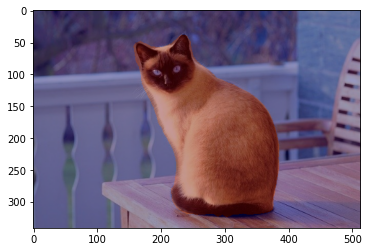

In [123]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0)
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

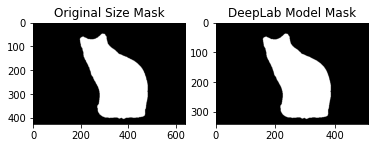

In [124]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

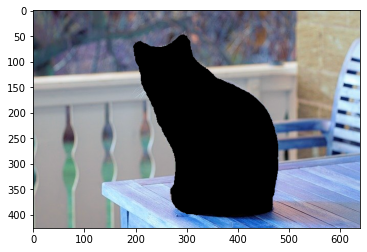

In [125]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cat_img_bg)
plt.show()

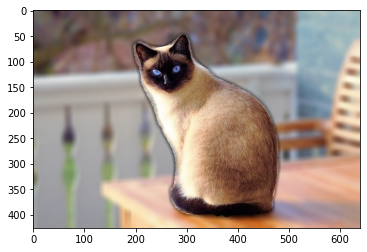

In [126]:
cat_img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

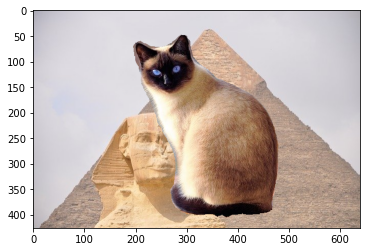

In [127]:
cat_resized = cv2.resize(
    cat_img_orig, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))
serengeti_img_resized = cv2.resize(
    serengeti_img_orig, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))
cat_img_mask_resized = cv2.resize(
    cat_img_mask_color, (serengeti_img_orig.shape[1], cat_img_orig.shape[0]))

cat_serengeti_concat = np.where(
    cat_img_mask_resized == 255, cat_resized, serengeti_img_resized)

plt.imshow(cv2.cvtColor(cat_serengeti_concat, cv2.COLOR_BGR2RGB))
plt.show()

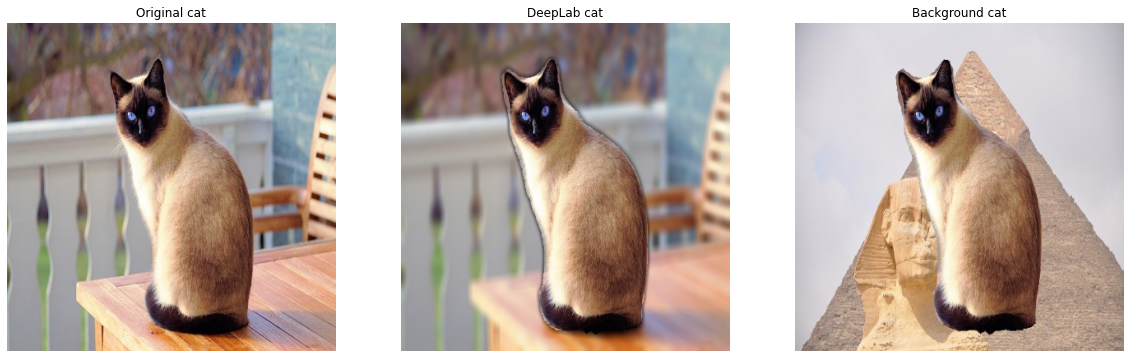

In [131]:
plt.figure(figsize=(20,20))
ax = plt.subplot(2,3,4)
plt.axis('off')
cat_img_orig_resized = cv2.resize(cat_img_orig, (400, 400))
plt.imshow(cv2.cvtColor(cat_img_orig_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Original cat')

ax = plt.subplot(2,3,5)
plt.axis('off')
cat_img_concat_resized = cv2.resize(cat_img_concat, (400, 400))
plt.imshow(cv2.cvtColor(cat_img_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('DeepLab cat')

ax = plt.subplot(2,3,6)
plt.axis('off')
cat_serengeti_concat_resized = cv2.resize(cat_serengeti_concat, (400, 400))
plt.imshow(cv2.cvtColor(cat_serengeti_concat_resized, cv2.COLOR_BGR2RGB))
ax.set_title('Background cat')


plt.show()

----------------------------------------------------------------------------------------------------------------------

## Blur 문제 해결

Mask 이미지는 0과 1로 나눠져 있어서 경계선이 생긴다. 그래서 일반 Blur 함수가 아닌 부드러운 곡선의 형태를 띄고 있는 Gaussian Blur를 사용했다.

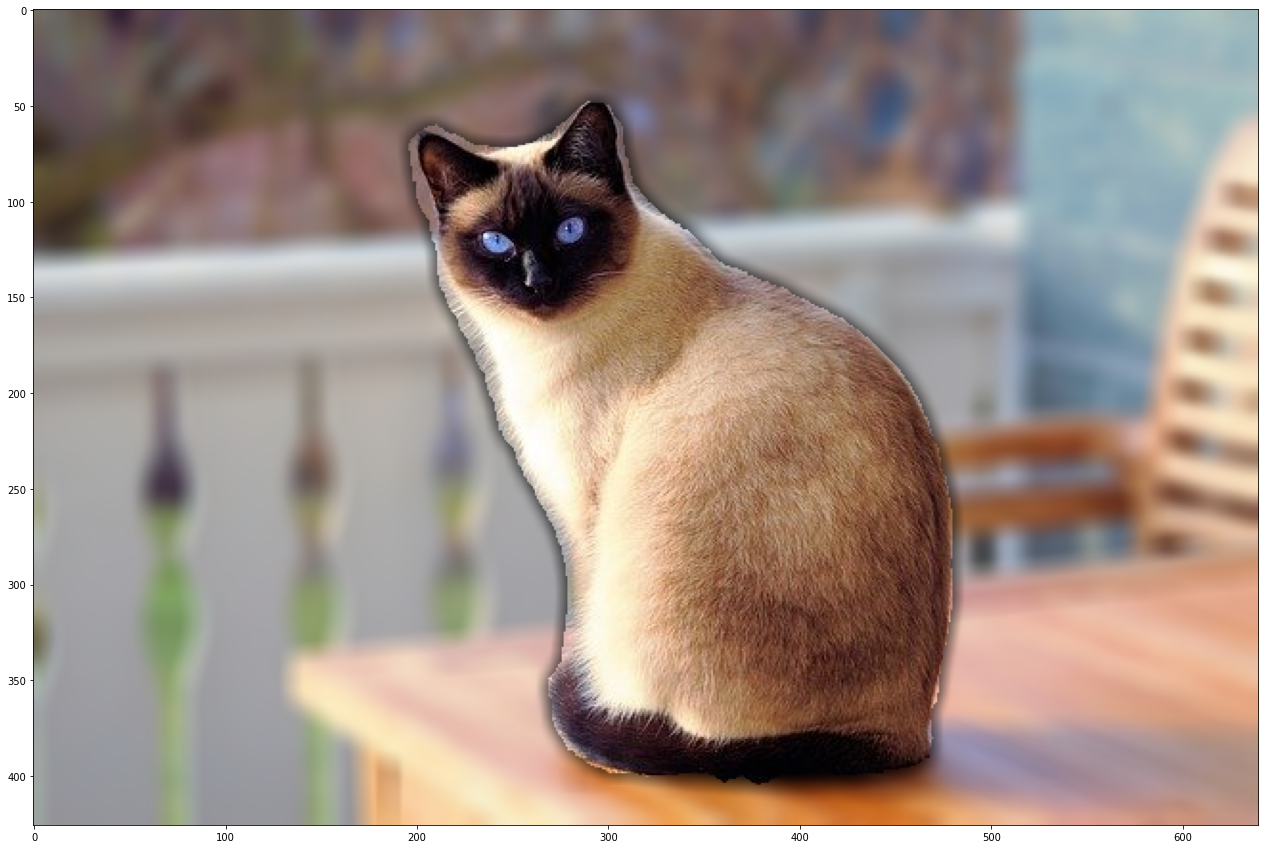

In [144]:
# original image
fig = plt.figure(figsize=(30, 15))
plt.imshow(cv2.cvtColor(cat_img_concat, cv2.COLOR_BGR2RGB), cmap=plt.cm.binary_r)

----------------------------------------------------------------------------------------------------------------------

# 회고

저작권 무료 남자 사진과 고양이 사진으로 아웃포커싱을 만들고 크로마키 배경도 합성해보았다. 

Problem
- 경계선이 띄어져있는 것이 매우 부자연스러워 보인다.(Mask 이미지는 0과 1로 나눠져 있어서 경계선이 생긴다.)
- 복잡한 포즈를 하고 있는 물체라면 object 일부분이 잘리는 문제가 발생할 것으로 예상된다.

Solution
- 경계선 문제는 일반 Blur 함수가 아닌 부드러운 곡선의 형태를 띄고 있는 Gaussian Blur를 사용했다.
- Segmentation에서 모델의 성능이 좋더라도 물체가 얇다면 Mask를 씌우는 데 어려움이 있습니다. 해결방안으로는 근본적으로 사진 화질을 고화질로 높여야한다.